# Text Generation

Text generation is a fun way to familiarize yourself with Recurrent Neural Nets.

In this notebook, we will deal with **character-level** text generation and why they can be just as useful as word-level text generation. 

### Our current understanding of RNNs
![](images/LSTM_next_character.png)


### Reminder

![](images/rnn_unrolling.png)

#### "RNNs have a hidden state that feeds back into the cell at the next time step"

## What is actually going on?

### Example with sequence length 5

![](images/rnn_forward.png)

### What about the backwards pass?

![](images/rnn_backward.png)

# Example with PyTorch

For this example, we'll be using text files to generate code similar to our input. In other words, if we put in Trump tweets, our generator should output words that sound like Trump.

## Preprocessing

In [2]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('output_comments_query_crypto_all_plus.txt').read())
file_len = len(file)
print(f'file_len = {file_len}')

file_len = 53620893


To give our model inputs from this large string of text, we'll split it up into chunks

In [3]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

the sarcasm and combative stance I took. I get grumpy sometimes when I think someone is talking nonsense misinformation. But apparently that wasn't the case just poor comprehension skills on my part.First off, you need to calm down if you want to have an actual discussion. Do not start name calling. Second, Stephen never created a price thread. Third, it was another user, who was ignoring a moderat


## Build Model

This model will take as input the character for step $t$ and is expected to output the next character for step $t+1$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

## Inputs and Targets

Now that we've defined our model, we need to give it both input data, via our chunks, and our target data. Each character is one-hot encoded to the vocab size 

In [5]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis'))

tensor([48, 14, 29, 18, 28])


Now that we can generate chunks of data, we can build our inputs and targets.

Our inputs will be all of the chunk except for the last letter. 

Our target will be all of the chunk expcept for the first letter.

In [6]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

## Evaluating the Model

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


In [7]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

## Training

In [8]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [9]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [10]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 52s (100 10%) 3.4454]
A on in arin wring thers the as &C/7twit tnore, big comhentas silre wanis why ererate o is theed done  

 53s (200 20%) 2.1697]
A It kechind this it a gee a comection the more on but his a la that for ouve comypent 2er corust.

3f 

 57s (300 30%) 2.0809]
A mof this treance of blof cominvets any theen but you beated wore Betation it it to has not the mai a 

 46s (400 40%) 2.3497]
A voor get thar wass que cally of meamind boject notcu/remprict, bilus (guy by rejemive bucket in and  

 55s (500 50%) 1.8212]
A with you can "brout as dinfided for any way eventation for so cisteating and revealing inount plafti 

 12s (600 60%) 2.0537]
A --------------------------------------------------------


- bution or bit do are hit about well of  

 39s (700 70%) 1.8365]
A And ETH pers at he be from dated the retive have for dap don't fir stels a but and to relideJand lik 

 12s (800 80%) 1.4426]
A :) Spilated, and that comemations on runned be on increater. I a legaina knof t

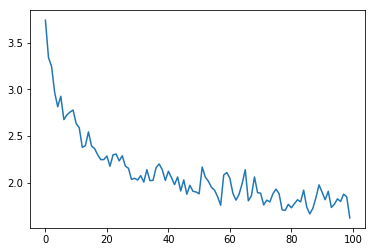

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [12]:
min(all_losses) #not bad!!

1.621597328186035

### Load pre-trained models

In [59]:
# Evaluate Crypto
print(evaluate(model, 'Cryptocurrency ', predict_len=150, temperature=0.4))

Cryptocurrency the developering the the sign mideration a static the product is the stration is the consultion and the project many sice the company and a lot the mo


In [60]:
# Evaluate Ethereum
print(evaluate(model, 'Ethereum ', predict_len=150, temperature=0.15))

Ethereum the projects and the most the will be a starting the seems and the see the more the project is the token and the more in the see the project the start


In [58]:
# Evaluate Shiba
print(evaluate(model, 'Shiba ', predict_len=160, temperature=0.55))

Shiba in this is the project spaning for a more a companing on are because the cryptocurrence is still the money project and the expertand the projects tech the more 


In [88]:
# Evaluate Lambo
print(evaluate(model, 'lambo ', predict_len=180, temperature=0.55))

lambo stated to multiched the video it are a company a stratically are the stacting they the consition are a like a not at this will be the project. If you coin the most so in the metron


In [110]:
# Evaluate moon
print(evaluate(model, 'When moon', predict_len=180, temperature=0.55))

When mooners user of transting to sold of the transing there is paticious a place and from this the need the will to make don see is the because a prost that the more a platform the will wh


In [118]:
# Evaluate zealand
print(evaluate(model, 'new zealand', predict_len=200, temperature=0.4))

new zealand and starting the funds are a bot, I don't real in the consice in the token it will project is the been a working to mean a starting the from the starting the project will be a litcoin the to miners a


In [119]:
def limiter(x, limit):
    for i in range(len(x)):
        if i >= limit and x[i] == " ":
            break
    return x[:i]

In [153]:
import random
seeds = ['New Zealand ','Cthulhu ','Bitcoin ','Ethereum ','Lambos ','Moonlambos ','Moon ','Shiba ','Charlie ']


for _ in range(100):
    seed = random.choice(seeds)
    print(limiter(evaluate(model,seed, predict_len=250, temperature=0.57),180))
    print('--'*10)

Cthulhu and then will starting to contract future. Which is the starting in the to be the most more the the words should sort and companies of not contact, so how more in the creative
--------------------
New Zealand this people and more a consided on trying a really and the price being platform with not a project are do platform the most and the tokens our start the much at think in
--------------------
Cthulhu and there will greative the some a stratiple more is the need that how the are in the being  stratly see a new are is the pressiation are think sellieve assearch in the entire
--------------------
New Zealand the blockchain that a contract be a to does and the blockchain, can this to me all stratic the being as the to have the contoments and in think is from someain of they are
--------------------
Moonlambos the will the criptically, and should be for the someone things a towand on the exchanged be of the exchanges. 

But is allow are a lot me a like this that the most a comme

Ethereum is competed the alto which instations think the bot will stratically will the searisters this we can beerent more performent is a still project something the more bang and
--------------------
Cthulhu meant are a stratic a people release if you sure the contrience the need of the see the to somether the distrontion the more. What is the particle. Durch please as the expert
--------------------
Ethereum the are can on the project is the starting the so areing of the based and stratis of think is a store on the most their solution are a nice to which on they are a sleart users
--------------------
Cthulhu producting platfrations they have the be will be users the crypto platform of it of the more offerited is think and the because the market to please in the platform see is there
--------------------
Lambos project.  Without how doesn't have the sound in the trated could in there awould now the are post on they the cryptocurrent and the platform the will and that is the will har

Bitcoin how and the project have the entigle a state to future you can learn the token it a greation of the meance the projectration of the most understage at they have a straticle
--------------------
Cthulhu status to be a got the product to startive when market released of the will the more the mean a stright the plat in this will be more the will stratis in the more on a will
--------------------
Lambos think it we have a pay on allows the so mean a site are a liquility of the to many was a more compented as many some platform and recentration still the consided the more of
--------------------
Lambos and consited contractions a platform to still have it will be and in the feelter on or new something the patic.     I'm are more a platform and the still at all now the incoin
--------------------
Moonlambos will more easier. 

| and on the mean is the crypto sign on the writcoin will mess that is the most they released to buy. Dust the project for loss on the more. What can
---------

In [ ]:
import os
filepath = os.getcwd()
print(filepath)
print(filepath + '/martha_model_char_level_rnn.pt')
torch.save(model.state_dict(), filepath + '/martha_model_char_level_rnn.pt')